## Load Data

These are ERP around either the movement start, i.e. for 'control' type muscle EMG - 80ms (or real EMG onset) and for 'control' type eme the onset of the EMS system. Also loads design matrix that includes single trial probas from applying the classifier to all trials.

In [5]:
import scipy.io as sio
import numpy as np
import os
import pandas as pd

path = '/Users/lukasgehrke/data/fastReach/data/eeglab2python'

pIDs = [12, 14, 15, 16, 17, 19, 20, 21, 22, 23]
elec = -1

df_all = pd.DataFrame()

for pID in pIDs:
    
    pID = 'sub-' + "%03d" % (pID)

    # load data
    # erp = sio.loadmat(path+os.sep+pID+os.sep+'eeg_tap.mat')['eeg_tap']
    erp = sio.loadmat(path+os.sep+pID+os.sep+'eeg_move.mat')['eeg_move']

    # load design matrix
    design = pd.read_csv(path+os.sep+pID+os.sep+'design.csv')
    
    # load mat bad noisy_trials_pre_move
    noisy_trials = sio.loadmat(path+os.sep+pID+os.sep+'noisy_trials_pre_move.mat')['noisy_trials_pre_move']
    
    # remove noisy trials from design & erp
    design = design.drop(noisy_trials.flatten(), axis=0).reset_index(drop=True)
    erp = np.delete(erp, noisy_trials.flatten(), axis=-1)
    # baseline correction
    baseline_time = np.arange(474,500)
    erp = erp - erp[:,baseline_time,:].mean(axis=-2)[:,np.newaxis,:]
    
    # c3 = 7 - c4 = 24 from erp
    # rp = erp[7,:,:] - erp[24,:,:]
    # elec_erp = pd.DataFrame(rp).transpose()
    elec_erp = pd.DataFrame(erp[elec,:,:]).transpose()

    # add 'condition', 'control' and 'id' from design with elec_
    elec_erp['condition'] = design['condition']
    elec_erp['control'] = design['control']
    elec_erp['id'] = design['id']
    elec_erp['delta_ems'] = design['delta_tap_ems']
    elec_erp['proba'] = design['proba']
    elec_erp['ed-rd'] = design['ed'] - design['rd']

    df_all = pd.concat([df_all, elec_erp], axis=0)

## Select Data

<AxesSubplot: >

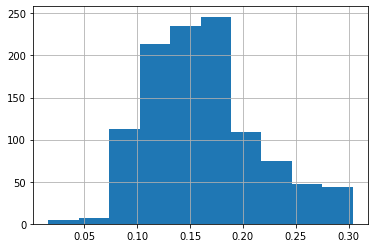

In [6]:
max_delay_between_ems_and_tap = .35 # 300ms
df_filtered = df_all[(df_all['delta_ems'].isna()) | (df_all['delta_ems'] <= max_delay_between_ems_and_tap)]

# Step 1: Temporarily ignore NaN values for outlier calculation
df_nonan = df_filtered.dropna(subset=['delta_ems'])

# Step 2: Calculate IQR and determine thresholds for outliers
Q1 = df_nonan['delta_ems'].quantile(0.25)
Q3 = df_nonan['delta_ems'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Filter outliers based on calculated thresholds
df_cleaned = df_nonan[(df_nonan['delta_ems'] >= lower_bound) & (df_nonan['delta_ems'] <= upper_bound)]

# Step 4: Include original NaN rows
df_final = pd.concat([df_cleaned, df_filtered[df_filtered['delta_ems'].isna()]])

# Ensure the index is sorted after concatenation if necessary
df_filtered = df_final.sort_index()

df_filtered['delta_ems'].hist()

## Main Effect 'Movement': Statistics & Plot ERPs yV

In [11]:
# %%capture

import pymer4 as pymer4
from pymer4.models import Lmer

df_test = df_filtered.copy()

# drop column control
df_test = df_test.drop(columns='control')

# aggregate data by id and condition
df_test = df_test.groupby(['id', 'condition']).mean().reset_index()

# select columns 524:574 and the last six columns
s_to_test = list(range(537, 562))
# indices = s_to_test + [df_test.shape[1]-6, df_test.shape[1]-5, df_test.shape[1]-4, df_test.shape[1]-3, df_test.shape[1]-2, df_test.shape[1]-1]
indices = s_to_test + [0, 1]
df_test = df_test.iloc[:,indices]

# rename time columns in df_test to 'time_'
df_test.columns = ['time_' + str(col) if isinstance(col, int) else col for col in df_test.columns]

chi2 = np.zeros(len(s_to_test))
p_values = np.zeros(len(s_to_test))
i = 0
for erp_tp in df_test.columns[:-2]:

    full_model = Lmer(erp_tp + " ~ condition + (1|id)", data = df_test)
    full_model.fit(REML=False, summarize=False)
    null_model = Lmer(erp_tp + " ~ 1 + (1|id)", data = df_test)
    null_model.fit(REML=False, summarize=False)

    # likelihood ratio test using pymer4 lrt
    lrt = pymer4.stats.lrt([full_model, null_model])
    chi2[i] = lrt.T.iloc[-4,1]
    p_values[i] = lrt.T.iloc[-2,1]

    i += 1

# correct for multiple comparisons
from statsmodels.stats.multitest import multipletests
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

boundary (singular) fit: see help('isSingular') 

boundary (singular) fit: see help('isSingular') 



erp plot of all three main conditions with sig marking model comparison main effect statistics.

In [13]:
lrt

,model,npar,AIC,BIC,log-likelihood,deviance,Chisq,Df,P-val,Sig
0,time_559~1+(1|id),3,192.188935,196.392527,-93.094467,186.188935,,,,
1,time_559~condition+(1|id),5,187.912187,194.918174,-88.956094,177.912187,8.276747,2.0,0.015949,*


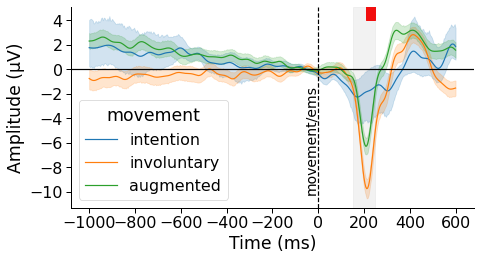

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

df = df_filtered.copy()

# drop columns delta_ems and ib
df = df.drop(['delta_ems', 'ed-rd', 'proba'], axis=1)

# format df from wide to long keeping 'participant' and 'condition' as id variables
df = pd.melt(df, id_vars=['id', 'condition', 'control'], var_name='time', value_name='voltage')
df.time = df.time - 500
df.time = df.time / 250

# remove times < 1s and > 1s
df = df[(df.time >= -1) & (df.time <= .6)]

df.time = df.time * 1000

# rename ems_random to involuntary
df.condition = df.condition.replace('ems_random', 'involuntary')
df.condition = df.condition.replace('ems_bci', 'augmented')
df.condition = df.condition.replace('baseline', 'intention')

# rename column 'condition' to 'movement'
df = df.rename(columns={'condition': 'movement'})

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    # sns.lineplot(x='time', y='voltage', hue='condition', style='control', data=df, ax=ax, errorbar='ci')
    sns.lineplot(x='time', y='voltage', hue='movement', data=df, ax=ax, errorbar='ci')
    # sns.lineplot(x='time', y='voltage', hue='control', data=df, ax=ax, errorbar='ci')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude (μV)')

    # xline at 0 with text label 's'
    ax.axvline(0, color='black', linestyle='--')
    ax.text(-60, -10, 'movement/ems', fontsize=14, rotation=90)

    # yline at 0
    ax.axhline(0, color='black', linestyle='-')

    # mark significant time points from p_values
    for i in range(len(pvals_corrected)):
        if pvals_corrected[i] < .05:
            loc = 150 + (i * 1/250 * 1000)
            # ax.text(loc, 4, '□', fontsize=12)
            square = patches.Rectangle((loc, 4), 4, 4, linewidth=1, edgecolor='r', facecolor='r')
            ax.add_patch(square)

    # add a grey background to the y axis range 100 - 300ms
    ax.axvspan(150, 250, color='grey', alpha=0.1)

    # save as eps
    # plt.savefig('/Users/lukasgehrke/Desktop/erp.eps', format='eps', dpi=300)
    # save as pdf
    plt.tight_layout()
    plt.savefig('/Users/lukasgehrke/Desktop/erp.pdf', format='pdf', dpi=300)

## Post-hoc contrast movement conditions

compute permutation t-test between condition involuntary and augmented_ems trials as well as between intention and augmented_muscle trials.

This was not directly a contrast in the previously plotted main effect but since we wanted to compare the relavent this we directly focused on this analyses.

In [14]:
from mne.stats import permutation_t_test
n_permutations = 100000

df_test = df_filtered.copy()

# select columns 524:574 and the last six columns
s_to_test = list(range(537, 562))
indices = s_to_test + [df_test.shape[1]-6, df_test.shape[1]-5, df_test.shape[1]-4, df_test.shape[1]-3, df_test.shape[1]-2, df_test.shape[1]-1]
df_test = df_test.iloc[:,indices]
df_test = df_test.drop(['delta_ems', 'proba', 'ed-rd'], axis=1)
df_test_agg = df_test.groupby(['condition', 'control', 'id']).mean().reset_index()

# drop condition ems_random when control is muscle
df_test_agg = df_test_agg[~((df_test_agg['condition'] == 'ems_random') & (df_test_agg['control'] == 'muscle'))]


# contrast intention and augmented/muscle
data_baseline = df_test_agg[df_test_agg['condition'] == 'baseline']
data_baseline = data_baseline[data_baseline['id'] != 23]
data_ems_bci_muscle = df_test_agg[(df_test_agg['condition'] == 'ems_bci') & (df_test_agg['control'] == 'muscle')].reset_index(drop=True)
diff_base_aug = data_ems_bci_muscle.iloc[:,3:] - data_baseline.iloc[:,3:]
# test
t_base_aug, p_base_aug, H0 = permutation_t_test(diff_base_aug.to_numpy(), n_permutations, n_jobs=None)

# contrast involuntary and augmented/bci
data_involuntary = df_test_agg[df_test_agg['condition'] == 'ems_random'].reset_index(drop=True)
data_ems_bci_muscle = df_test_agg[(df_test_agg['condition'] == 'ems_bci') & (df_test_agg['control'] == 'ems')].reset_index(drop=True)
diff_inv_aug = data_ems_bci_muscle.iloc[:,3:] - data_involuntary.iloc[:,3:]
# test
t_inv_aug, p_inv_aug, H0 = permutation_t_test(diff_inv_aug.to_numpy(), n_permutations, n_jobs=None)

Permuting 255 times (exact test)...
Permuting 511 times (exact test)...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


plots the difference waves between involuntary and augmented_ems as well as between intention and augmented_muscle and marks significant points using ttest results above

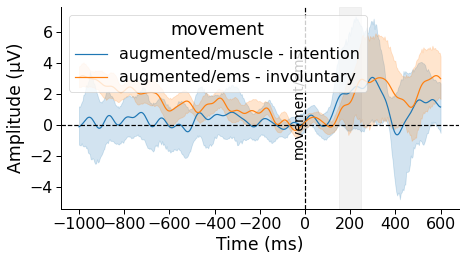

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sig_thresh = .05
df = df_filtered.copy()
df = df.drop(['delta_ems', 'ed-rd', 'proba'], axis=1)
df = df.groupby(['condition', 'control', 'id']).mean().reset_index()
df = df[~((df['condition'] == 'ems_random') & (df['control'] == 'muscle'))]
df = df[~((df['id'] == 23) & (df['condition'] == 'baseline'))]

# difference intention - augmented/muscle
data_baseline = df[df['condition'] == 'baseline'].reset_index(drop=True)
data_ems_bci_muscle = df[(df['condition'] == 'ems_bci') & (df['control'] == 'muscle')].reset_index(drop=True)
diff_base_aug = data_ems_bci_muscle.iloc[:,3:] - data_baseline.iloc[:,3:]

# difference involuntary - augmented/ems
data_involuntary = df[df['condition'] == 'ems_random'].reset_index(drop=True)
data_ems_bci_ems = df[(df['condition'] == 'ems_bci') & (df['control'] == 'ems')].reset_index(drop=True)
diff_inv_aug = data_ems_bci_ems.iloc[:,3:] - data_involuntary.iloc[:,3:]

# wide to long
diff_base_aug['movement'] = 'augmented/muscle - intention'
diff_base_aug['id'] = data_baseline['id']
diff_inv_aug['movement'] = 'augmented/ems - involuntary'
diff_inv_aug['id'] = data_involuntary['id']

df = pd.concat([diff_base_aug, diff_inv_aug], axis=0)

# wide to long
df = pd.melt(df, id_vars=['movement', 'id'], var_name='time', value_name='voltage')
df.time = df.time - 500 
df.time = df.time / 250

# remove times < 1s and > 1s
df = df[(df.time >= -1) & (df.time <= .6)]
df.time = df.time * 1000

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    # sns.lineplot(x='time', y='voltage', hue='condition', style='control', data=df, ax=ax, errorbar='ci')
    sns.lineplot(x='time', y='voltage', hue='movement', data=df, ax=ax, errorbar='ci')
    # sns.lineplot(x='time', y='voltage', hue='control', data=df, ax=ax, errorbar='ci')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude (μV)')

    # xline at 0 with text label 's'
    ax.axvline(0, color='black', linestyle='--')
    ax.text(-60, -2, 'movement/ems', fontsize=14, rotation=90)

    # yline at 0
    ax.axhline(0, color='black', linestyle='--')

    # mark significant time points from p_values
    for i in range(len(p_inv_aug)):
        if p_inv_aug[i] < sig_thresh:
            loc = 150 + (i * 1/250 * 1000)
            square = patches.Rectangle((loc, 4), 4, 4, linewidth=1, edgecolor='r', facecolor='r')
            ax.add_patch(square)

    # mark significant time points from p_values
    for i in range(len(p_base_aug)):
        if p_base_aug[i] < sig_thresh:
            loc = 150 + (i * 1/250 * 1000)
            square = patches.Rectangle((loc, -4), 4, 4, linewidth=1, edgecolor='blue', facecolor='blue')
            ax.add_patch(square)

    # add a grey background to the y axis range 100 - 300ms
    ax.axvspan(150, 250, color='grey', alpha=0.1)

    # move legend to the right
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # save as eps
    plt.tight_layout()
    plt.savefig('/Users/lukasgehrke/Desktop/erp_diff.pdf', format='pdf', dpi=300)

### Descriptives for reporting data going into statistics

In [ ]:
# summarize df_filtered by condition and control
# df_filtered.groupby(['condition', 'control']).mean()

# count number of trials per condition and control
df_filtered.groupby(['condition', 'control']).count()

## Correlation Proba - ERP

Is there a moderating effect of proba on how the conditions impact the ERP?

For those trials where the EMS was triggered by the classifier, is there an effect of the classifier probability on the ERP? -> This really is the only interesting question!!!

In [8]:
%%capture

import pymer4 as pymer4
from pymer4.models import Lmer
from scipy.stats import pearsonr

df_test = df_filtered[(df_filtered['condition'] == 'ems_bci') & (df_filtered['control'] == 'ems')].copy()
# df_test = df_filtered[(df_filtered['condition'] == 'ems_bci')].copy()
# df_test = df_filtered.copy()

# select columns 524:574 and the last six columns
# s_to_test = list(range(537, 562))
# indices = s_to_test + [df_test.shape[1]-6, df_test.shape[1]-5, df_test.shape[1]-4, df_test.shape[1]-3, df_test.shape[1]-2, df_test.shape[1]-1]
# df_test = df_test.iloc[:,indices]

# rename time columns in df_test to 'time_'
df_test.columns = ['time_' + str(col) if isinstance(col, int) else col for col in df_test.columns]

s_to_test = list(range(0, df_test.shape[1]-6))

chi2 = np.zeros(len(s_to_test))
p_values = np.zeros(len(s_to_test))
estimate = np.zeros((len(s_to_test), 3))
i = 0
for erp_tp in df_test.columns[:-6]:

    # corrcoeff[i] = df_test[['proba', erp_tp]].corr().iloc[0,1]

    # # Assuming erp_tp is defined earlier in your code and is a valid column name in df_test
    # corr_coefficient, p_value = pearsonr(df_test['proba'], df_test[erp_tp])

    # # Storing the correlation coefficient
    # corrcoeff[i] = corr_coefficient

    # # Now you can also use the p_value for significance testing
    # # For example, to check if the correlation is significant at the 0.05 level:
    # if p_value < 0.05:
    #     print(f"Correlation between 'proba' and '{erp_tp}' is significant (p = {p_value:.4f}).")
    # else:
    #     print(f"Correlation between 'proba' and '{erp_tp}' is not significant (p = {p_value:.4f}).")

    # full_model = Lmer(erp_tp + " ~ proba * condition + (condition|id) + (proba|id)", data = df_test)
    full_model = Lmer(erp_tp + " ~ proba + (proba|id)", data = df_test)
    full_model.fit(REML=False, summarize=False)
    # null_model = Lmer(erp_tp + " ~ condition + (condition|id) + (proba|id)", data = df_test)
    null_model = Lmer(erp_tp + " ~ 1 + (1|id)", data = df_test)
    null_model.fit(REML=False, summarize=False)

    # likelihood ratio test using pymer4 lrt
    lrt = pymer4.stats.lrt([full_model, null_model])
    chi2[i] = lrt.T.iloc[-4,1]
    p_values[i] = lrt.T.iloc[-2,1]
    estimate[i,0] = full_model.coefs.T.iloc[0,1]
    estimate[i,1] = full_model.coefs.T.iloc[1,1] # ci
    estimate[i,2] = full_model.coefs.T.iloc[2,1]

    i += 1

# correct for multiple comparisons
from statsmodels.stats.multitest import multipletests
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

plot the estimate as an ERP

In [ ]:
# correct for multiple comparisons
from statsmodels.stats.multitest import multipletests
reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({'time': df_test.columns[:-6], 'p_value': pvals_corrected, 'estimate': estimate[:,0], 'ci25': estimate[:,1], 'ci975': estimate[:,2]})

# remove 'time_' from time column
df['time'] = df['time'].str[5:]
df['time'] = df['time'].astype(int)
df['time'] = (df['time'] - 500) / 250 * 1000

pvals_corrected = pvals_corrected[(df['time'] >= -100) & (df['time'] <= 400)]

# select data points from -1000 to 600ms
df = df[(df['time'] >= -100) & (df['time'] <= 400)]

# and p_values

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    # sns.lineplot(x='time', y='voltage', hue='condition', style='control', data=df, ax=ax, errorbar='ci')
    sns.lineplot(x='time', y='estimate', data=df, ax=ax)
    # sns.lineplot(x='time', y='voltage', hue='control', data=df, ax=ax, errorbar='ci')

    # add confidence intervals
    ax.fill_between(df['time'], df['ci25'], df['ci975'], alpha=.3)

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Estimate')

    # xline at 0 with text label 's'
    ax.axvline(0, color='black', linestyle='--')
    # ax.text(-60, -10, 'movement/ems', fontsize=14, rotation=90)

    # yline at 0
    ax.axhline(0, color='black', linestyle='--')

    # mark significant time points from p_values
    for i in range(len(pvals_corrected)):
        if pvals_corrected[i] < .05:
            loc = (i * 1/250 * 1000)
            square = patches.Rectangle((loc, 4), 4, 4, linewidth=1, edgecolor='r', facecolor='r')
            ax.add_patch(square)

    # add a grey background to the y axis range 100 - 300ms
    ax.axvspan(150, 250, color='grey', alpha=0.1)

    # save as eps
    plt.tight_layout()
    plt.savefig('/Users/lukasgehrke/Desktop/proba_reg.pdf', format='pdf', dpi=300)

In [ ]:
# matplolib scatterplot of proba and erp_tp at min_p_idx with linear regression line
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress

# find index of smallest p_value
min_p_idx = np.where(pvals_corrected == pvals_corrected.min())
timepoint = min_p_idx[0] * 1/250 * 1000

df_test = df_filtered[(df_filtered['condition'] == 'ems_bci') & (df_filtered['control'] == 'ems')].copy()
df_test.columns = ['time_' + str(col) if isinstance(col, int) else col for col in df_test.columns]

# remove outliers based on erp
# df_test = df_test[(df_test[df_test.columns[min_p_idx[0][0]+500]] >= -20) & (df_test[df_test.columns[min_p_idx[0][0]+500]] <= 20)]

# compute slope and intercept
slope, intercept, r_value, p_value, std_err = linregress(df_test['proba'], df_test[df_test.columns[min_p_idx[0][0]+500]])

with sns.plotting_context('paper', font_scale = 1.8):
    
    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    sns.scatterplot(x='proba', y=df_test.columns[min_p_idx[0][0]+500], hue='id', data=df_test, ax=ax)

    # hide legend
    ax.get_legend().remove()

    # add linear regression line
    x = np.linspace(0, 1, 100)
    y = slope * x + intercept
    ax.plot(x, y, color='black')

    # set y axis range
    ax.set_ylim(-35, 20)

    # add text with p_value
    ax.text(.5, -5, 'slope = ' + str(np.round(slope,3)) + ', p = ' + str(np.round(p_value,3)), fontsize=16)

    ax.set_xlabel('Classifier Probability')
    ax.set_ylabel('Amplitude (µV) at ' + str(timepoint[0]) + 'ms')

    # save as eps
    plt.tight_layout()
    plt.savefig('/Users/lukasgehrke/Desktop/proba_scatter.pdf', format='pdf', dpi=300)

# resources

In [ ]:
elec = -1

intention_elec = intention[:,elec,:]
augmented_elec = augmented[:,elec,:]
involuntary_elec = involuntary[:,elec,:]
augmented_muscle_elec = augmented_muscle[:,elec,:]
augmented_ems_elec = augmented_ems[:,elec,:]

# baseline correction range from 474:499
baseline_time = np.arange(474,500)
intention_elec = intention_elec - intention_elec[:,baseline_time].mean(axis=-1)[:,np.newaxis]
augmented_elec = augmented_elec - augmented_elec[:,baseline_time].mean(axis=-1)[:,np.newaxis]
involuntary_elec = involuntary_elec - involuntary_elec[:,baseline_time].mean(axis=-1)[:,np.newaxis]
augmented_muscle_elec = augmented_muscle_elec - augmented_muscle_elec[:,baseline_time].mean(axis=-1)[:,np.newaxis]
augmented_ems_elec = augmented_ems_elec - augmented_ems_elec[:,baseline_time].mean(axis=-1)[:,np.newaxis]

df_intention = pd.DataFrame(intention_elec)
df_augmented = pd.DataFrame(augmented_elec)
df_involuntary = pd.DataFrame(involuntary_elec)
df_augmented_muscle = pd.DataFrame(augmented_muscle_elec)
df_augmented_ems = pd.DataFrame(augmented_ems_elec)

df = pd.concat([df_intention, df_augmented, df_involuntary, df_augmented_muscle, df_augmented_ems], axis=0)

# delete first 250 columns (baseline) and last 350 columns (after movement)
df = df.iloc[:,250:-351]

# add variable 'condition' with 3 levels (intention, augmented, involuntary) to df
df['condition'] = ['intention']*len(pIDs) + ['augmented']*len(pIDs) + ['involuntary']*len(pIDs) + ['augmented_muscle']*len(pIDs) + ['augmented_ems']*len(pIDs)
# add variable 'participant' with 10 levels (pID) to df (repeated pID vector 3 times)
df['participant'] = np.tile(pIDs, 5)

df_test = df.copy()

# format df from wide to long keeping 'participant' and 'condition' as id variables
df = pd.melt(df, id_vars=['participant', 'condition'], var_name='time', value_name='voltage')
df.time = df.time - 500
df.time = df.time / 250

# remove times < 1s and > 1s
df = df[(df.time >= -1) & (df.time <= .6)]

df.time = df.time * 1000

In [ ]:
# plot proba by condition box plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='condition', y='proba', data=df_filtered)
plt.show()

In [ ]:
s = 548

# remove outliers on 555
df_filtered = df_filtered[np.abs(df_filtered[s]) < 100]

# scatter proba and 555

import matplotlib.pyplot as plt
plt.scatter(df_filtered['proba'], df_filtered[s])
# plot line
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(df_filtered['proba'], df_filtered[s])
plt.plot(df_filtered['proba'], slope*df_filtered['proba'] + intercept, color='red')
plt.title('r = ' + str(r_value))
plt.xlabel('proba')
plt.ylabel('555')
plt.show()


In [ ]:
# make time variable from -1000 to 600 ms in steps of 4 ms, should be the size of estimates
time = np.arange(-1000, 596, 4)

# create df with estimates and time
df_estimates = pd.DataFrame(lrt[:,0], columns=['intercept', 'aug_ems', 'aug_muscle', 'intention', 'involuntary'])
df_estimates['time'] = time

# format df from wide to long keeping 'time' as id variable
df_estimates = pd.melt(df_estimates, id_vars=['time'], var_name='condition', value_name='estimate')

# remove intercept from df_estimates
df_estimates = df_estimates[df_estimates.condition != 'intercept']

from statsmodels.stats.multitest import multipletests
lrt_corrected = multipletests(lrt[:,1], alpha=0.05, method='fdr_bh')[1]
df_estimates['significant'] = np.repeat(lrt_corrected < 0.05, len(df_estimates) // len(lrt_corrected))

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    sns.lineplot(x='time', y='estimate', hue='condition', data=df_estimates, ax=ax)

    # Iterate over conditions to plot significant points
    conditions = df_estimates['condition'].unique()
    for condition in conditions:
        # Filter for significant points for the current condition
        significant_points = df_estimates[(df_estimates['condition'] == condition) & (df_estimates['significant'])]
        # Plot significant points
        ax.scatter(significant_points['time'], significant_points['estimate'], color='red', s=10, label='Significant' if condition == conditions[0] else "")

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('estimate')

    # xline at 0
    ax.axvline(0, color='black', linestyle='--')
    # yline at 0
    ax.axhline(0, color='black', linestyle='--')

    # Adjust legend to avoid repeating 'Significant' label
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys())


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df_filtered.copy()
df = df.drop(['delta_ems', 'ed-rd', 'proba'], axis=1)
df = df.groupby(['condition', 'control', 'id']).mean().reset_index()
df = df[~((df['condition'] == 'ems_random') & (df['control'] == 'muscle'))]
df = df[~((df['id'] == 23) & (df['condition'] == 'baseline'))]

# difference intention - augmented/muscle
data_baseline = df[df['condition'] == 'baseline'].reset_index(drop=True)
data_ems_bci_muscle = df[(df['condition'] == 'ems_bci') & (df['control'] == 'muscle')].reset_index(drop=True)
diff_base_aug = data_ems_bci_muscle.iloc[:,3:] - data_baseline.iloc[:,3:]

# difference involuntary - augmented/ems
data_involuntary = df[df['condition'] == 'ems_random'].reset_index(drop=True)
data_ems_bci_muscle = df[(df['condition'] == 'ems_bci') & (df['control'] == 'ems')].reset_index(drop=True)
diff_inv_aug = data_ems_bci_muscle.iloc[:,3:] - data_involuntary.iloc[:,3:]

# wide to long
diff_base_aug['movement'] = 'intention - augmented/muscle'
diff_base_aug['id'] = data_baseline['id']
diff_inv_aug['movement'] = 'involuntary - augmented/ems'
diff_inv_aug['id'] = data_involuntary['id']

diff = pd.concat([diff_base_aug, diff_inv_aug], axis=0)

# wide to long
diff = pd.melt(diff, id_vars=['movement', 'id'], var_name='time', value_name='voltage')
diff.time = diff.time - 500 
diff.time = diff.time / 250

# diff_base_aug['movement'] = 'intention - augmented/muscle'
# diff_base_aug['id'] = data_baseline['id']
# diff_inv_aug['movement'] = 'involuntary - augmented/ems'
# diff_inv_aug['id'] = data_involuntary['id']
# diff = pd.concat([diff_base_aug, diff_inv_aug], axis=0)

# # wide to long
# diff = pd.melt(diff, id_vars=['movement', 'id'], var_name='time', value_name='voltage')
# diff.time = diff.time - 500
# diff.time = diff.time / 250 * 1000

# remove times < 1s and > 1s
# df = df[(df.time >= -1) & (df.time <= .6)]

# df.time = df.time * 1000

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    # sns.lineplot(x='time', y='voltage', hue='condition', style='control', data=df, ax=ax, errorbar='ci')
    sns.lineplot(x='time', y='voltage', hue='movement', data=diff, ax=ax, errorbar='ci')
    # sns.lineplot(x='time', y='voltage', hue='control', data=df, ax=ax, errorbar='ci')

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Amplitude (uV)')

    # xline at 0 with text label 's'
    ax.axvline(0, color='black', linestyle='--')
    # ax.text(-60, -10, 'movement/ems', fontsize=14, rotation=90)

    # yline at 0
    ax.axhline(0, color='black', linestyle='--')

    # # mark significant time points from p_values
    # for i in range(len(pvals_corrected)):
    #     if pvals_corrected[i] < .05:
    #         loc = 100 + (i * 1/250 * 1000)
    #         ax.text(loc, 4, '*', fontsize=12)

    # # add a grey background to the y axis range 100 - 300ms
    # ax.axvspan(100, 300, color='grey', alpha=0.1)

In [ ]:
# simple line plot of variable 'corrcoeff' with x-axis 'time' and y-axis 'correlation coefficient'
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({'time': df_test.columns[:-6], 'corrcoeff': p_values})

with sns.plotting_context('paper', font_scale = 1.8):

    ### Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(7,4))
    fig.patch.set_alpha(1)

    sns.despine() #bottom=True, left=True

    sns.lineplot(x='time', y='corrcoeff', data=df, ax=ax)

    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Correlation coefficient')

    # xline at 0 with text label 's'
    ax.axvline(0, color='black', linestyle='--')
    # ax.text(-60, -0.5, 'movement/ems', fontsize=14, rotation=90)

    # yline at 0
    ax.axhline(0, color='black', linestyle='--')